<a href="https://colab.research.google.com/github/galievaz/bike-sharing-project/blob/main/project-notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir

  Using cached setuptools-62.1.0-py3-none-any.whl (1.1 MB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 59.5.0
    Uninstalling setuptools-59.5.0:
      Successfully uninstalled setuptools-59.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
pytorch-lightning 1.5.10 requires setuptools==59.5.0, but you have setuptools 62.1.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.4/952.4 KB 30.5 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 62.1.0
    Uninstalling setuptools-62.1.0:
      Successfully uninstalled setuptools-62.1.0
ERROR: pip's dependency resolver does not currentl

In [28]:
!pip install kaggle

In [29]:
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [30]:
import json
kaggle_username = "dulic11221"
kaggle_key = "0a2244ded4f31a255a918ba1a934143b"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

In [31]:
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

bike-sharing-demand.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [32]:
import pandas as pd
from autogluon.tabular import TabularPredictor

In [33]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv('./train.csv')
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [34]:
features=['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed']
target=['count']
train=train[list(features+target)]

In [35]:
train['datetime'] = pd.to_datetime(train['datetime'], format='%Y-%m-%d %H:%M:%S')

In [36]:
train.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
count                  int64
dtype: object

In [37]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,977.000000


In [38]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv('./test.csv')
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [39]:
test['datetime'] = pd.to_datetime(test['datetime'], format='%Y-%m-%d %H:%M:%S')

In [40]:
# Same thing as train and test dataset
submission = pd.read_csv('./sampleSubmission.csv')
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [41]:
submission['datetime'] = pd.to_datetime(submission['datetime'], format='%Y-%m-%d %H:%M:%S')

# Step 3: Train a model using AutoGluon’s Tabular **Prediction**

In [42]:
predictor = TabularPredictor(label="count", learner_kwargs={"ignored_columns": ["casual", "registered"]},  eval_metric='root_mean_squared_error').fit(
    train_data=train,
    time_limit=600,
    presets="best_quality"
    
   
)

No path specified. Models will be saved in: "AutogluonModels/ag-20220422_143424/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220422_143424/"
AutoGluon Version:  0.4.0
Python Version:     3.7.13
Operating System:   Linux
Train Data Rows:    10886
Train Data Columns: 9
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:      

# **Review AutoGluon's training run with ranking of models that did the best.**

In [43]:
#predictor = TabularPredictor.load('AutogluonModels/ag-20220419_084331')
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -52.994791      18.839666  501.748953                0.001277           0.451197            3       True         14
1   RandomForestMSE_BAG_L2  -53.353580      18.476158  422.680922                0.623459          30.444662            2       True         12
2          LightGBM_BAG_L2  -54.921043      18.138651  417.567591                0.285952          25.331331            2       True         11
3          CatBoost_BAG_L2  -55.476709      17.928978  445.521762                0.076279          53.285502            2       True         13
4        LightGBMXT_BAG_L2  -60.790096      21.509765  450.122399                3.657066          57.886139            2       True         10
5    KNeighborsDist_BAG_L1  -84.125061       0.104694    0.072251         

{'leaderboard':                      model   score_val  pred_time_val    fit_time  \
 0      WeightedEnsemble_L3  -52.994791      18.839666  501.748953   
 1   RandomForestMSE_BAG_L2  -53.353580      18.476158  422.680922   
 2          LightGBM_BAG_L2  -54.921043      18.138651  417.567591   
 3          CatBoost_BAG_L2  -55.476709      17.928978  445.521762   
 4        LightGBMXT_BAG_L2  -60.790096      21.509765  450.122399   
 5    KNeighborsDist_BAG_L1  -84.125061       0.104694    0.072251   
 6      WeightedEnsemble_L2  -84.125061       0.107079    0.951911   
 7    KNeighborsUnif_BAG_L1 -101.546199       0.105267    0.049789   
 8   RandomForestMSE_BAG_L1 -116.621736       1.855475   20.028315   
 9     ExtraTreesMSE_BAG_L1 -124.637158       0.525751    5.043195   
 10         CatBoost_BAG_L1 -130.758048       0.149796  178.196670   
 11         LightGBM_BAG_L1 -131.054162       2.453421   43.443413   
 12       LightGBMXT_BAG_L1 -131.460909      12.185747  101.594290   
 13  

In [44]:
predictor.feature_importance(train)

Computing feature importance via permutation shuffling for 9 features using 1000 rows with 3 shuffle sets...
	242.26s	= Expected runtime (80.75s per shuffle set)
	139.04s	= Actual runtime (Completed 3 of 3 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
datetime,187.805207,1.050238,0.000005,3,193.823189,181.787225
holiday,0.065995,0.072276,0.127281,3,0.480143,-0.348153
season,-0.589732,0.153975,0.989012,3,0.292560,-1.472025
weather,-0.886189,0.144323,0.995637,3,-0.059201,-1.713176
workingday,-1.923087,0.434829,0.991691,3,0.568534,-4.414708
windspeed,-2.159030,0.531257,0.990204,3,0.885132,-5.203192
temp,-2.303888,0.255385,0.997965,3,-0.840503,-3.767273
atemp,-2.554457,0.256883,0.998323,3,-1.082489,-4.026424
humidity,-2.681977,0.599549,0.991874,3,0.753506,-6.117460


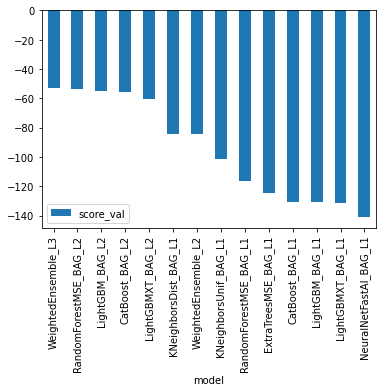

In [45]:
predictor.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val")

# Create predictions from test dataset

In [46]:
predictions = predictor.predict(test)
predictions.head()

0    24.431293
1    42.688961
2    47.203384
3    49.738876
4    52.408520
Name: count, dtype: float32

In [47]:
#NOTE: Kaggle will reject the submission if we don't set everything to be > 0.
# How many negative values do we have?
any(predictions<0)

False

# Set predictions to submission dataframe, save, and submit

In [48]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [49]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100% 188k/188k [00:02<00:00, 86.0kB/s]
Successfully submitted to Bike Sharing Demand

View submission via the command line or in the web browser under the competition's page - My Submissions

In [50]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                                          date                 description                         status    publicScore  privateScore  
------------------------------------------------  -------------------  ----------------------------------  --------  -----------  ------------  
submission.csv                                    2022-04-22 14:47:20  first raw submission                complete  1.78902      1.78902       
submission_new_hpo.csv                            2022-04-22 09:28:46  new features with hyperparameters4  complete  0.73435      0.73435       
submission_dropped_added_features.csv             2022-04-22 07:29:04  new features2                       complete  0.73046      0.73046       
submission.csv                                    2022-04-22 07:11:05  first raw submission                complete  1.80462      1.80462       


Initial score of 1.79572

# **Step 4: Exploratory Data Analysis and Creating an additional feature**

Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.


In [51]:
# create a new feature
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour

test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour

train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,2011,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,336,2012,12,19,19
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,241,2012,12,19,20
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,168,2012,12,19,21
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,129,2012,12,19,22


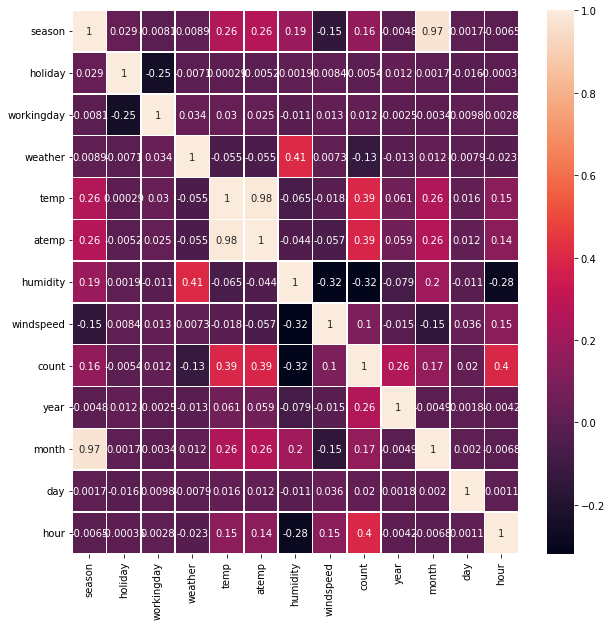

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))
train_corr=train.drop('datetime', axis=1).corr()
sns.heatmap(train_corr, annot=True, linewidths=.5, ax=ax)

There are a high correlations between features "season" and "month" , "temp" and "atemp",  need to drop one of features in each pair. Let's choose season and temp

In [53]:
train=train.drop([ 'temp', 'month'], axis=1)
train

,datetime,season,holiday,workingday,weather,atemp,humidity,windspeed,count,year,day,hour
0,2011-01-01 00:00:00,1,0,0,1,14.395,81,0.0000,16,2011,1,0
1,2011-01-01 01:00:00,1,0,0,1,13.635,80,0.0000,40,2011,1,1
2,2011-01-01 02:00:00,1,0,0,1,13.635,80,0.0000,32,2011,1,2
3,2011-01-01 03:00:00,1,0,0,1,14.395,75,0.0000,13,2011,1,3
4,2011-01-01 04:00:00,1,0,0,1,14.395,75,0.0000,1,2011,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,19.695,50,26.0027,336,2012,19,19
10882,2012-12-19 20:00:00,4,0,1,1,17.425,57,15.0013,241,2012,19,20
10883,2012-12-19 21:00:00,4,0,1,1,15.910,61,15.0013,168,2012,19,21
10884,2012-12-19 22:00:00,4,0,1,1,17.425,61,6.0032,129,2012,19,22


In [54]:
test=test.drop([ 'temp', 'month'], axis=1)
test

,datetime,season,holiday,workingday,weather,atemp,humidity,windspeed,year,day,hour
0,2011-01-20 00:00:00,1,0,1,1,11.365,56,26.0027,2011,20,0
1,2011-01-20 01:00:00,1,0,1,1,13.635,56,0.0000,2011,20,1
2,2011-01-20 02:00:00,1,0,1,1,13.635,56,0.0000,2011,20,2
3,2011-01-20 03:00:00,1,0,1,1,12.880,56,11.0014,2011,20,3
4,2011-01-20 04:00:00,1,0,1,1,12.880,56,11.0014,2011,20,4
...,...,...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,12.880,60,11.0014,2012,31,19
6489,2012-12-31 20:00:00,1,0,1,2,12.880,60,11.0014,2012,31,20
6490,2012-12-31 21:00:00,1,0,1,1,12.880,60,11.0014,2012,31,21
6491,2012-12-31 22:00:00,1,0,1,1,13.635,56,8.9981,2012,31,22


In [55]:
train.corr()

,season,holiday,workingday,weather,atemp,humidity,windspeed,count,year,day,hour
season,1.000000,0.029368,-0.008126,0.008879,0.264744,0.190610,-0.147121,0.163439,-0.004797,0.001729,-0.006546
holiday,0.029368,1.000000,-0.250491,-0.007074,-0.005215,0.001929,0.008409,-0.005393,0.012021,-0.015877,-0.000354
workingday,-0.008126,-0.250491,1.000000,0.033772,0.024660,-0.010880,0.013373,0.011594,-0.002482,0.009829,0.002780
weather,0.008879,-0.007074,0.033772,1.000000,-0.055376,0.406244,0.007261,-0.128655,-0.012548,-0.007890,-0.022740
atemp,0.264744,-0.005215,0.024660,-0.055376,1.000000,-0.043536,-0.057473,0.389784,0.058540,0.011866,0.140343
humidity,0.190610,0.001929,-0.010880,0.406244,-0.043536,1.000000,-0.318607,-0.317371,-0.078606,-0.011335,-0.278011
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.057473,-0.318607,1.000000,0.101369,-0.015221,0.036157,0.146631
count,0.163439,-0.005393,0.011594,-0.128655,0.389784,-0.317371,0.101369,1.000000,0.260403,0.019826,0.400601
year,-0.004797,0.012021,-0.002482,-0.012548,0.058540,-0.078606,-0.015221,0.260403,1.000000,0.001800,-0.004234
day,0.001729,-0.015877,0.009829,-0.007890,0.011866,-0.011335,0.036157,0.019826,0.001800,1.000000,0.001132


In [56]:
# Consider new feature weekend
# selecting rows based on condition
rslt_df = train[(train['workingday'] == 0) &
          (train['holiday']==0)]
  
print('\nResult dataframe :\n', rslt_df)


Result dataframe :
                  datetime  season  holiday  workingday  weather   atemp  \
0     2011-01-01 00:00:00       1        0           0        1  14.395   
1     2011-01-01 01:00:00       1        0           0        1  13.635   
2     2011-01-01 02:00:00       1        0           0        1  13.635   
3     2011-01-01 03:00:00       1        0           0        1  14.395   
4     2011-01-01 04:00:00       1        0           0        1  14.395   
...                   ...     ...      ...         ...      ...     ...   
10809 2012-12-16 19:00:00       4        0           0        1  17.425   
10810 2012-12-16 20:00:00       4        0           0        2  19.695   
10811 2012-12-16 21:00:00       4        0           0        2  18.940   
10812 2012-12-16 22:00:00       4        0           0        2  20.455   
10813 2012-12-16 23:00:00       4        0           0        2  17.425   

       humidity  windspeed  count  year  day  hour  
0            81     0.000

In [57]:
import numpy as np
train['weekend']=np.where((train['workingday']==0) & (train['holiday']==0), 1,0)
test['weekend']=np.where((test['workingday']==0) & (test['holiday']==0), 1,0)
train

,datetime,season,holiday,workingday,weather,atemp,humidity,windspeed,count,year,day,hour,weekend
0,2011-01-01 00:00:00,1,0,0,1,14.395,81,0.0000,16,2011,1,0,1
1,2011-01-01 01:00:00,1,0,0,1,13.635,80,0.0000,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,13.635,80,0.0000,32,2011,1,2,1
3,2011-01-01 03:00:00,1,0,0,1,14.395,75,0.0000,13,2011,1,3,1
4,2011-01-01 04:00:00,1,0,0,1,14.395,75,0.0000,1,2011,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,19.695,50,26.0027,336,2012,19,19,0
10882,2012-12-19 20:00:00,4,0,1,1,17.425,57,15.0013,241,2012,19,20,0
10883,2012-12-19 21:00:00,4,0,1,1,15.910,61,15.0013,168,2012,19,21,0
10884,2012-12-19 22:00:00,4,0,1,1,17.425,61,6.0032,129,2012,19,22,0


In [58]:
test

,datetime,season,holiday,workingday,weather,atemp,humidity,windspeed,year,day,hour,weekend
0,2011-01-20 00:00:00,1,0,1,1,11.365,56,26.0027,2011,20,0,0
1,2011-01-20 01:00:00,1,0,1,1,13.635,56,0.0000,2011,20,1,0
2,2011-01-20 02:00:00,1,0,1,1,13.635,56,0.0000,2011,20,2,0
3,2011-01-20 03:00:00,1,0,1,1,12.880,56,11.0014,2011,20,3,0
4,2011-01-20 04:00:00,1,0,1,1,12.880,56,11.0014,2011,20,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,12.880,60,11.0014,2012,31,19,0
6489,2012-12-31 20:00:00,1,0,1,2,12.880,60,11.0014,2012,31,20,0
6490,2012-12-31 21:00:00,1,0,1,1,12.880,60,11.0014,2012,31,21,0
6491,2012-12-31 22:00:00,1,0,1,1,13.635,56,8.9981,2012,31,22,0


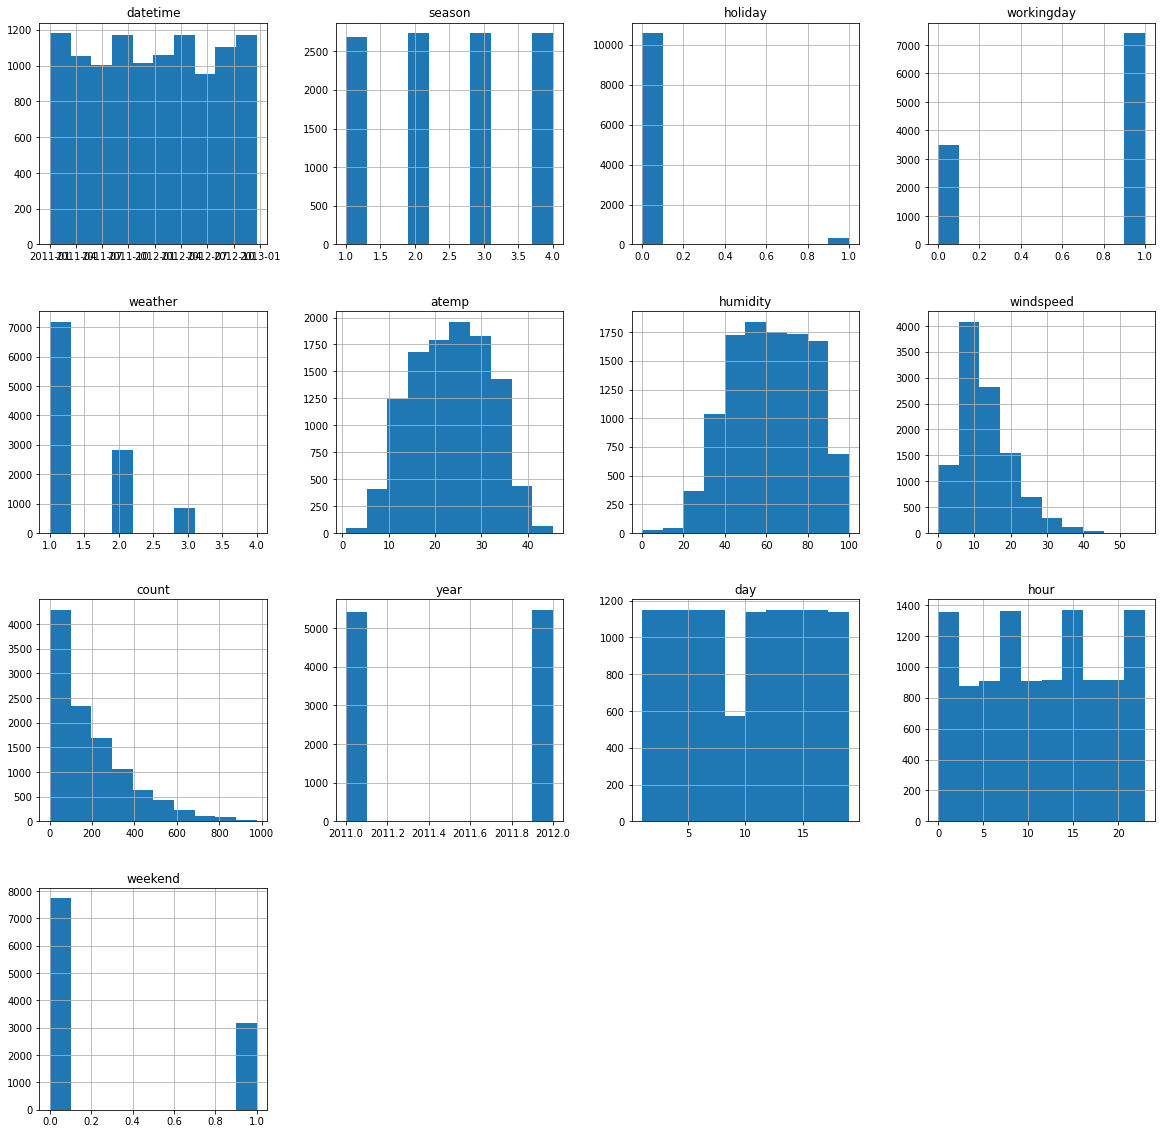

In [59]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist(figsize=(20,20));

In [60]:
train.describe()

,season,holiday,workingday,weather,atemp,humidity,windspeed,count,year,day,hour,weekend
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,23.655084,61.886460,12.799395,191.574132,2011.501929,9.992559,11.541613,0.290557
std,1.116174,0.166599,0.466159,0.633839,8.474601,19.245033,8.164537,181.144454,0.500019,5.476608,6.915838,0.454040
min,1.000000,0.000000,0.000000,1.000000,0.760000,0.000000,0.000000,1.000000,2011.000000,1.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,16.665000,47.000000,7.001500,42.000000,2011.000000,5.000000,6.000000,0.000000
50%,3.000000,0.000000,1.000000,1.000000,24.240000,62.000000,12.998000,145.000000,2012.000000,10.000000,12.000000,0.000000
75%,4.000000,0.000000,1.000000,2.000000,31.060000,77.000000,16.997900,284.000000,2012.000000,15.000000,18.000000,1.000000
max,4.000000,1.000000,1.000000,4.000000,45.455000,100.000000,56.996900,977.000000,2012.000000,19.000000,23.000000,1.000000


# **Make category types for these so models know they are not just numbers**



*   AutoGluon originally sees these as ints, but in reality they are int representations of a category.

*   Setting the dtype to category will classify these as categories in AutoGluon.



In [61]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'atemp',
       'humidity', 'windspeed', 'count', 'year', 'day', 'hour', 'weekend'],
      dtype='object')

In [62]:
for each in train.columns:
    print('Feature', each, 'has county of unique values: ', train[each].nunique(), '( ', train[each].unique(),  ')\n with number of values for each unique: ', train[each].value_counts(), '\n')

Feature datetime has county of unique values:  10886 (  ['2011-01-01T00:00:00.000000000' '2011-01-01T01:00:00.000000000'
 '2011-01-01T02:00:00.000000000' ... '2012-12-19T21:00:00.000000000'
 '2012-12-19T22:00:00.000000000' '2012-12-19T23:00:00.000000000'] )
 with number of values for each unique:  2011-01-01 00:00:00    1
2012-05-01 21:00:00    1
2012-05-01 13:00:00    1
2012-05-01 14:00:00    1
2012-05-01 15:00:00    1
                      ..
2011-09-02 04:00:00    1
2011-09-02 05:00:00    1
2011-09-02 06:00:00    1
2011-09-02 07:00:00    1
2012-12-19 23:00:00    1
Name: datetime, Length: 10886, dtype: int64 

Feature season has county of unique values:  4 (  [1 2 3 4] )
 with number of values for each unique:  4    2734
2    2733
3    2733
1    2686
Name: season, dtype: int64 

Feature holiday has county of unique values:  2 (  [0 1] )
 with number of values for each unique:  0    10575
1      311
Name: holiday, dtype: int64 

Feature workingday has county of unique values:  2 (  [0

In [63]:
train['windspeed'].value_counts()

0.0000     1313
8.9981     1120
11.0014    1057
12.9980    1042
7.0015     1034
15.0013     961
6.0032      872
16.9979     824
19.0012     676
19.9995     492
22.0028     372
23.9994     274
26.0027     235
27.9993     187
30.0026     111
31.0009      89
32.9975      80
35.0008      58
39.0007      27
36.9974      22
43.0006      12
40.9973      11
43.9989       8
46.0022       3
56.9969       2
47.9988       2
51.9987       1
50.0021       1
Name: windspeed, dtype: int64

In [64]:
train.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
atemp                float64
humidity               int64
windspeed            float64
count                  int64
year                   int64
day                    int64
hour                   int64
weekend                int64
dtype: object

In [65]:
def f(x):
    if (x > 7) and (x <= 9):
        return 'Early morning'
    elif (x > 9) and (x <= 11 ):
        return 'Morning'
    elif (x > 11) and (x <= 13):
        return'Lunch'
    elif (x > 13) and (x <= 17) :
        return 'Afternoon'
    elif (x > 17) and (x <= 21):
        return'Evening'
    elif (x > 21) or (x < 7):
        return'Late Night'
        
train['part day'] = train['hour'].apply(f)
test['part day'] = test['hour'].apply(f)

In [66]:
def f(x):
    if (x > 0) and (x <= 12):
        return 'Cold atemp'
    elif (x > 12) and (x <= 25 ):
        return 'Mild atemp'
    elif (x > 25):
        return 'Hot atemp'
train['level atemp'] = train['atemp'].apply(f)
test['level atemp'] = test['atemp'].apply(f)
train

,datetime,season,holiday,workingday,weather,atemp,humidity,windspeed,count,year,day,hour,weekend,part day,level atemp
0,2011-01-01 00:00:00,1,0,0,1,14.395,81,0.0000,16,2011,1,0,1,Late Night,Mild atemp
1,2011-01-01 01:00:00,1,0,0,1,13.635,80,0.0000,40,2011,1,1,1,Late Night,Mild atemp
2,2011-01-01 02:00:00,1,0,0,1,13.635,80,0.0000,32,2011,1,2,1,Late Night,Mild atemp
3,2011-01-01 03:00:00,1,0,0,1,14.395,75,0.0000,13,2011,1,3,1,Late Night,Mild atemp
4,2011-01-01 04:00:00,1,0,0,1,14.395,75,0.0000,1,2011,1,4,1,Late Night,Mild atemp
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,19.695,50,26.0027,336,2012,19,19,0,Evening,Mild atemp
10882,2012-12-19 20:00:00,4,0,1,1,17.425,57,15.0013,241,2012,19,20,0,Evening,Mild atemp
10883,2012-12-19 21:00:00,4,0,1,1,15.910,61,15.0013,168,2012,19,21,0,Evening,Mild atemp
10884,2012-12-19 22:00:00,4,0,1,1,17.425,61,6.0032,129,2012,19,22,0,Late Night,Mild atemp


In [67]:
def f(x):
    if (x > 0) and (x <= 20 ):
        return 'Not humid'
    elif (x > 20) and (x <= 60 ):
        return 'Mild humid'
    elif (x > 60):
        return 'Very humid'
train['level humidity'] = train['humidity'].apply(f)
test['level humidity'] = test['humidity'].apply(f)
train

,datetime,season,holiday,workingday,weather,atemp,humidity,windspeed,count,year,day,hour,weekend,part day,level atemp,level humidity
0,2011-01-01 00:00:00,1,0,0,1,14.395,81,0.0000,16,2011,1,0,1,Late Night,Mild atemp,Very humid
1,2011-01-01 01:00:00,1,0,0,1,13.635,80,0.0000,40,2011,1,1,1,Late Night,Mild atemp,Very humid
2,2011-01-01 02:00:00,1,0,0,1,13.635,80,0.0000,32,2011,1,2,1,Late Night,Mild atemp,Very humid
3,2011-01-01 03:00:00,1,0,0,1,14.395,75,0.0000,13,2011,1,3,1,Late Night,Mild atemp,Very humid
4,2011-01-01 04:00:00,1,0,0,1,14.395,75,0.0000,1,2011,1,4,1,Late Night,Mild atemp,Very humid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,19.695,50,26.0027,336,2012,19,19,0,Evening,Mild atemp,Mild humid
10882,2012-12-19 20:00:00,4,0,1,1,17.425,57,15.0013,241,2012,19,20,0,Evening,Mild atemp,Mild humid
10883,2012-12-19 21:00:00,4,0,1,1,15.910,61,15.0013,168,2012,19,21,0,Evening,Mild atemp,Very humid
10884,2012-12-19 22:00:00,4,0,1,1,17.425,61,6.0032,129,2012,19,22,0,Late Night,Mild atemp,Very humid


In [68]:
def f(x):
    if x == 0:
        return 'No wind'
    elif (x > 0) and (x <= 10 ):
        return 'Mild wind'
    elif (x > 10):
        return 'Very windy'
train['level windspeed'] = train['windspeed'].apply(f)
test['level windspeed'] = test['windspeed'].apply(f)
train

,datetime,season,holiday,workingday,weather,atemp,humidity,windspeed,count,year,day,hour,weekend,part day,level atemp,level humidity,level windspeed
0,2011-01-01 00:00:00,1,0,0,1,14.395,81,0.0000,16,2011,1,0,1,Late Night,Mild atemp,Very humid,No wind
1,2011-01-01 01:00:00,1,0,0,1,13.635,80,0.0000,40,2011,1,1,1,Late Night,Mild atemp,Very humid,No wind
2,2011-01-01 02:00:00,1,0,0,1,13.635,80,0.0000,32,2011,1,2,1,Late Night,Mild atemp,Very humid,No wind
3,2011-01-01 03:00:00,1,0,0,1,14.395,75,0.0000,13,2011,1,3,1,Late Night,Mild atemp,Very humid,No wind
4,2011-01-01 04:00:00,1,0,0,1,14.395,75,0.0000,1,2011,1,4,1,Late Night,Mild atemp,Very humid,No wind
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,19.695,50,26.0027,336,2012,19,19,0,Evening,Mild atemp,Mild humid,Very windy
10882,2012-12-19 20:00:00,4,0,1,1,17.425,57,15.0013,241,2012,19,20,0,Evening,Mild atemp,Mild humid,Very windy
10883,2012-12-19 21:00:00,4,0,1,1,15.910,61,15.0013,168,2012,19,21,0,Evening,Mild atemp,Very humid,Very windy
10884,2012-12-19 22:00:00,4,0,1,1,17.425,61,6.0032,129,2012,19,22,0,Late Night,Mild atemp,Very humid,Mild wind


In [69]:
boolean_columns=[ 'workingday', 'holiday']
for each in boolean_columns:
    train[each] = train[each].astype('bool')
    test[each] = test[each].astype('bool')

train.dtypes
test.dtypes

datetime           datetime64[ns]
season                      int64
holiday                      bool
workingday                   bool
weather                     int64
atemp                     float64
humidity                    int64
windspeed                 float64
year                        int64
day                         int64
hour                        int64
weekend                     int64
part day                   object
level atemp                object
level humidity             object
level windspeed            object
dtype: object

In [70]:
#categorical_columns=[ 'windspeed',  'holiday', 'workingday', 'weather', 'year', 'season', 'day', 'hour',  'part day', 'level atemp', 'level humidity', 'level windspeed']
categorical_columns=[ 'windspeed',  'holiday', 'workingday', 'weather', 'year', 'season', 'day', 'hour']
for each in categorical_columns:
    train[each] = train[each].astype('category')
    test[each] = test[each].astype('category')

train.dtypes
test.dtypes


datetime           datetime64[ns]
season                   category
holiday                  category
workingday               category
weather                  category
atemp                     float64
humidity                    int64
windspeed                category
year                     category
day                      category
hour                     category
weekend                     int64
part day                   object
level atemp                object
level humidity             object
level windspeed            object
dtype: object

# **Step 5: Rerun the model with the same settings as before, just with more added features and dropped 'temp' and 'season'**

In [71]:
predictor_new_features =TabularPredictor(label="count").fit(
    train_data=train,
    time_limit=600,
    presets="best_quality"
    #auto_stack=True
)

No path specified. Models will be saved in: "AutogluonModels/ag-20220422_144727/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220422_144727/"
AutoGluon Version:  0.4.0
Python Version:     3.7.13
Operating System:   Linux
Train Data Rows:    10886
Train Data Columns: 16
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11206.41 MB
	Train Data (Original)  Memory Usage: 3

Let's distill AutoGluon’s predictor, which is most accurate ensemble-predictor into single models which are simpler/faster and require less memory/compute. Distillation can produce a model that is more accurate than the same model fit directly on the original training data

In [72]:
#distilled_model_names = predictor_new_features.distill()

In [73]:
#model_to_deploy = distilled_model_names[0]
#predictions_nf=predictor_nf.predict(test, model=model_to_deploy)
#predictions_nf

In [74]:
#model_to_deploy

In [75]:
#predictor_nf = TabularPredictor.load("AutogluonModels/ag-20220419_092219/")
predictions_nf=predictor_new_features.predict(test)
predictions_nf

0        15.685522
1        14.307636
2        14.779604
3        11.361234
4         8.319632
           ...    
6488    280.082703
6489    206.661469
6490    168.705139
6491    128.231689
6492     89.135521
Name: count, Length: 6493, dtype: float32

In [76]:
#if predictions contain negative values
predictions_nf[predictions_nf < 0] = 0
predictions_nf

0        15.685522
1        14.307636
2        14.779604
3        11.361234
4         8.319632
           ...    
6488    280.082703
6489    206.661469
6490    168.705139
6491    128.231689
6492     89.135521
Name: count, Length: 6493, dtype: float32

In [77]:
submission["count"] = predictions_nf
submission.to_csv("submission_dropped_added_features.csv", index=False)

In [78]:
!kaggle competitions submit -c bike-sharing-demand -f submission_dropped_added_features.csv -m "new features2"

100% 188k/188k [00:02<00:00, 82.3kB/s]
Successfully submitted to Bike Sharing Demand

In [79]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                                          date                 description                         status    publicScore  privateScore  
------------------------------------------------  -------------------  ----------------------------------  --------  -----------  ------------  
submission_dropped_added_features.csv             2022-04-22 14:58:03  new features2                       complete  0.71571      0.71571       
submission.csv                                    2022-04-22 14:47:20  first raw submission                complete  1.78902      1.78902       
submission_new_hpo.csv                            2022-04-22 09:28:46  new features with hyperparameters4  complete  0.73435      0.73435       
submission_dropped_added_features.csv             2022-04-22 07:29:04  new features2                       complete  0.73046      0.73046       


# New Score of ?

# **Step 6: Hyper parameter optimization**

In [80]:
import autogluon.core as ag

nn_options = {  # specifies non-default hyperparameter values for neural network models
    'num_epochs': 10,  # number of training epochs (controls training time of NN models)
    'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True),  # learning rate used in training (real-valued hyperparameter searched on log-scale)
    'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'),  # activation function used in NN (categorical hyperparameter, default = first entry)
    'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1),  # dropout probability (real-valued hyperparameter)
}

gbm_options = {  # specifies non-default hyperparameter values for lightGBM gradient boosted trees
    'num_boost_round': 100,  # number of boosting rounds (controls training time of GBM models)
    'num_leaves': ag.space.Int(lower=26, upper=66, default=36),  # number of leaves in trees (integer hyperparameter)
}

hyperparameters = {  # hyperparameters of each model type
                   'GBM': gbm_options,
                   'NN_TORCH': nn_options,  # NOTE: comment this line out if you get errors on Mac OSX
                  }  # When these keys are missing from hyperparameters dict, no models of that type are trained

time_limit = 2*60  # train various models for ~2 min
num_trials = 5  # try at most 5 different hyperparameter configurations for each type of model
search_strategy = ['auto' ] # to tune hyperparameters using random search routine with a local scheduler

hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
    'num_trials': num_trials,
    'scheduler' : 'local',
    'searcher': search_strategy,
}

predictor_hpo = TabularPredictor(label='count').fit(
    train, time_limit=600,
    auto_stack=True,
    #hyperparameters=hyperparameters, hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
)

No path specified. Models will be saved in: "AutogluonModels/ag-20220422_145805/"
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220422_145805/"
AutoGluon Version:  0.4.0
Python Version:     3.7.13
Operating System:   Linux
Train Data Rows:    10886
Train Data Columns: 16
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11187.43 MB
	Train Data (Original)  Memory Usage: 3.31 MB (0.0% of available memory)
	I

In [81]:
predictor_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -30.820652      14.085320  532.729335                0.001640           0.553351            3       True         14
1          LightGBM_BAG_L2  -31.174225      12.940094  432.732580                0.590512          31.206190            2       True         11
2        LightGBMXT_BAG_L2  -31.611832      13.174962  431.765917                0.825380          30.239526            2       True         10
3          CatBoost_BAG_L2  -32.281640      12.667789  470.730268                0.318207          69.203878            2       True         13
4   RandomForestMSE_BAG_L2  -33.034324      13.130615  438.406486                0.781033          36.880095            2       True         12
5      WeightedEnsemble_L2  -34.161070      10.926902  351.660505         

{'leaderboard':                      model   score_val  pred_time_val    fit_time  \
 0      WeightedEnsemble_L3  -30.820652      14.085320  532.729335   
 1          LightGBM_BAG_L2  -31.174225      12.940094  432.732580   
 2        LightGBMXT_BAG_L2  -31.611832      13.174962  431.765917   
 3          CatBoost_BAG_L2  -32.281640      12.667789  470.730268   
 4   RandomForestMSE_BAG_L2  -33.034324      13.130615  438.406486   
 5      WeightedEnsemble_L2  -34.161070      10.926902  351.660505   
 6          LightGBM_BAG_L1  -36.067375       4.092721   52.103172   
 7        LightGBMXT_BAG_L1  -36.141963       5.627235   63.943061   
 8   RandomForestMSE_BAG_L1  -38.761768       0.610118   15.342217   
 9     ExtraTreesMSE_BAG_L1  -39.109623       0.605713    7.128915   
 10         CatBoost_BAG_L1  -39.452001       0.489414  219.330142   
 11  NeuralNetFastAI_BAG_L1  -46.431300       0.713240   43.621917   
 12   KNeighborsDist_BAG_L1  -84.125061       0.106431    0.026010   
 13  

In [82]:
#distilled_model_names = predictor_hpo.distill()

In [83]:
#model_to_deploy = distilled_model_names[0]
#predictions_hpo=predictor_hpo.predict(test, model=model_to_deploy)
#predictions_hpo

In [84]:
predictor

In [85]:
# save the model to disk
filename = 'finalized_model.pkl'
pickle.dump(predictor_new_features, open(filename, 'wb'))
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict(test)
predictions_hpo

NameError: ignored

In [ ]:
test

In [86]:
#predictor_hpo = TabularPredictor.load("AutogluonModels/ag-20220419_113702/")
#predictor_hpo = TabularPredictor.load("AutogluonModels/ag-20220419_115457/")
#predictor_hpo = TabularPredictor.load("AutogluonModels/ag-20220419_132403/")
predictions_hpo=predictor_hpo.predict(test)
predictions_hpo

0        15.480080
1        14.662064
2        14.782572
3        11.591188
4         8.461092
           ...    
6488    278.737854
6489    208.356308
6490    169.130447
6491    126.845741
6492     88.386597
Name: count, Length: 6493, dtype: float32

In [89]:
train

,datetime,season,holiday,workingday,weather,atemp,humidity,windspeed,count,year,day,hour,weekend,part day,level atemp,level humidity,level windspeed
0,2011-01-01 00:00:00,1,False,False,1,14.395,81,0.0000,16,2011,1,0,1,Late Night,Mild atemp,Very humid,No wind
1,2011-01-01 01:00:00,1,False,False,1,13.635,80,0.0000,40,2011,1,1,1,Late Night,Mild atemp,Very humid,No wind
2,2011-01-01 02:00:00,1,False,False,1,13.635,80,0.0000,32,2011,1,2,1,Late Night,Mild atemp,Very humid,No wind
3,2011-01-01 03:00:00,1,False,False,1,14.395,75,0.0000,13,2011,1,3,1,Late Night,Mild atemp,Very humid,No wind
4,2011-01-01 04:00:00,1,False,False,1,14.395,75,0.0000,1,2011,1,4,1,Late Night,Mild atemp,Very humid,No wind
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,False,True,1,19.695,50,26.0027,336,2012,19,19,0,Evening,Mild atemp,Mild humid,Very windy
10882,2012-12-19 20:00:00,4,False,True,1,17.425,57,15.0013,241,2012,19,20,0,Evening,Mild atemp,Mild humid,Very windy
10883,2012-12-19 21:00:00,4,False,True,1,15.910,61,15.0013,168,2012,19,21,0,Evening,Mild atemp,Very humid,Very windy
10884,2012-12-19 22:00:00,4,False,True,1,17.425,61,6.0032,129,2012,19,22,0,Late Night,Mild atemp,Very humid,Mild wind


In [87]:
# Remember to set all negative values to zero
any(predictions_hpo<0)
#predictions

False

In [88]:
#set
predictions_hpo[predictions_hpo < 0] = 0
predictions_hpo


0        15.480080
1        14.662064
2        14.782572
3        11.591188
4         8.461092
           ...    
6488    278.737854
6489    208.356308
6490    169.130447
6491    126.845741
6492     88.386597
Name: count, Length: 6493, dtype: float32

In [90]:
# Same submitting predictions
submission["count"] = predictions_hpo
submission.to_csv("submission_new_hpo.csv", index=False)

In [91]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters4"

100% 188k/188k [00:02<00:00, 68.7kB/s]
Successfully submitted to Bike Sharing Demand

In [92]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 10

fileName                                          date                 description                         status    publicScore  privateScore  
------------------------------------------------  -------------------  ----------------------------------  --------  -----------  ------------  
submission_new_hpo.csv                            2022-04-22 15:09:49  new features with hyperparameters4  complete  0.71498      0.71498       
submission_dropped_added_features.csv             2022-04-22 14:58:03  new features2                       complete  0.71571      0.71571       
submission.csv                                    2022-04-22 14:47:20  first raw submission                complete  1.78902      1.78902       
submission_new_hpo.csv                            2022-04-22 09:28:46  new features with hyperparameters4  complete  0.73435      0.73435       
submission_dropped_added_features.csv             2022-04-22 07:29:04  new features2                       complete  0.73046      

In [93]:
!kaggle competitions submissions -c bike-sharing-demand

fileName                                          date                 description                         status    publicScore  privateScore  
------------------------------------------------  -------------------  ----------------------------------  --------  -----------  ------------  
submission_new_hpo.csv                            2022-04-22 15:09:49  new features with hyperparameters4  complete  0.71498      0.71498       
submission_dropped_added_features.csv             2022-04-22 14:58:03  new features2                       complete  0.71571      0.71571       
submission.csv                                    2022-04-22 14:47:20  first raw submission                complete  1.78902      1.78902       
submission_new_hpo.csv                            2022-04-22 09:28:46  new features with hyperparameters4  complete  0.73435      0.73435       
submission_dropped_added_features.csv             2022-04-22 07:29:04  new features2                       complete  0.73046      

# New Score of 0.66675

# **# Step 7: Write a Report**
# Refer to the markdown file for the full report
# Creating plots and table for report

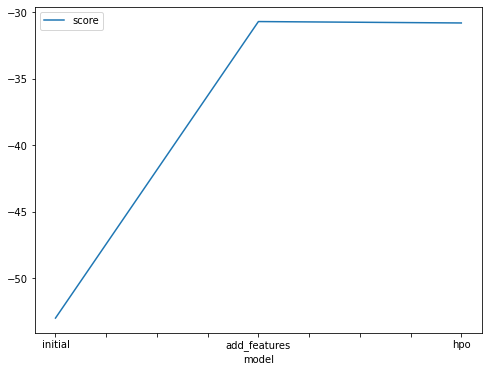

In [94]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        #"score": [1.79572 ,  0.78285, 0.45708],
        "score": [predictor.leaderboard(silent=True)['score_val'][0],
                  predictor_new_features.leaderboard(silent=True)['score_val'][0],
                  predictor_hpo.leaderboard(silent=True)['score_val'][0],
                  ]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

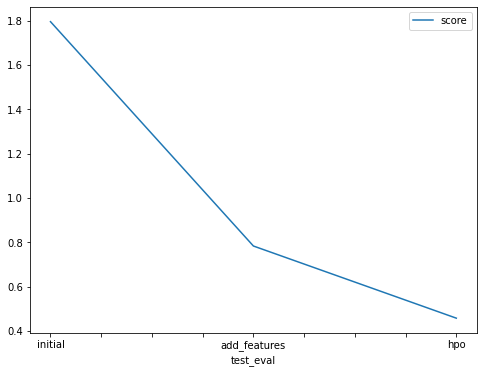

In [95]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.79572 ,  0.78285, 0.45708]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

# **Hyperparameter table**

In [96]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "Time Limit": [700, 700, 700],
    "Architecture Used": ["Default", "Default", "NN or GBM"],
    "Training Data": ["Standard", "New Features Added", "New Features Added"],
    "score": [1.79572 ,  0.78285, 0.45708]
})

,model,Time Limit,Architecture Used,Training Data,score
0,initial,700,Default,Standard,1.79572
1,add_features,700,Default,New Features Added,0.78285
2,hpo,700,NN or GBM,New Features Added,0.45708
